In [1]:
from math import log2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


from src.models.utils.create_batch import EarthDataTrain
from src.models.model.model import Generator, Discriminator, init_weights
from src.models.loss.wasserstein import gradient_penalty

# to clear outputs from cells
from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:


#######################################################
# Set Hyperparameters
#######################################################

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

LEARNING_RATE = 1e-4
NUM_EPOCHS = 80
BATCH_SIZE = 1
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
GEN_PRETRAIN_EPOCHS= 80 # number of epochs to pretrain generator

#######################################################


root_dir = Path.cwd().parent.parent # set the root directory as a Pathlib path
print(root_dir)

path_input_folder = root_dir / 'data/processed/input'
path_truth_folder = root_dir / 'data/processed/truth'

earth_dataset = EarthDataTrain(path_input_folder, path_truth_folder)

loader = DataLoader(
    earth_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

gen = Generator(in_chan=4, out_chan=4, scale_factor=8, chan_base=32, chan_min=32, chan_max=64, cat_noise=True).to(device)
critic = Discriminator(in_chan=8, out_chan=8, scale_factor=8, chan_base=32, chan_min=32, chan_max=64).to(device)

# initialize weights
gen.apply(init_weights)
critic.apply(init_weights)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.0, 0.9))

gen.train()
critic.train()


for epoch in range(NUM_EPOCHS):
    print('epoch', epoch)


    for batch_idx, data in enumerate(loader):
        x_truth = data['truth'].to(device)
        x_up = data['upsampled'].to(device)
        x_input = data['input'].to(device)

        # pre-train the generator with simple MSE loss
        if epoch < GEN_PRETRAIN_EPOCHS:
            criterion = nn.MSELoss()
            gen_fake = gen(x_input)
            loss_mse = criterion(gen_fake, x_truth)
            gen.zero_grad()
            loss_mse.backward()
            opt_gen.step()

        # after pre-training of generator, enter the 
        # full training loop and train critic (e.g. discriminator) too
        else:
            # train critic
            for _ in range(CRITIC_ITERATIONS):
                fake = gen(x_input)
                
                critic_real = critic(torch.cat([x_truth, x_up], dim=1)).view(-1)
                critic_fake = critic(torch.cat([fake, x_up], dim=1)).view(-1)
                
                gp = gradient_penalty(critic, 
                                    torch.cat([x_truth, x_up], dim=1), # real
                                    torch.cat([fake, x_up], dim=1),  # fake
                                    device=device)

                loss_critic = (
                        -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
                    )
                
                critic.zero_grad()
                loss_critic.backward(retain_graph=True)
                opt_critic.step()

            # train generator after every N critic iterations
            gen_fake = critic(torch.cat([fake, x_up], dim=1)).reshape(-1)
            loss_gen = -torch.mean(gen_fake)
            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()
            
clear_output(wait=False)

cuda
/home/tim/Documents/earth-mantle-surrogate
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62


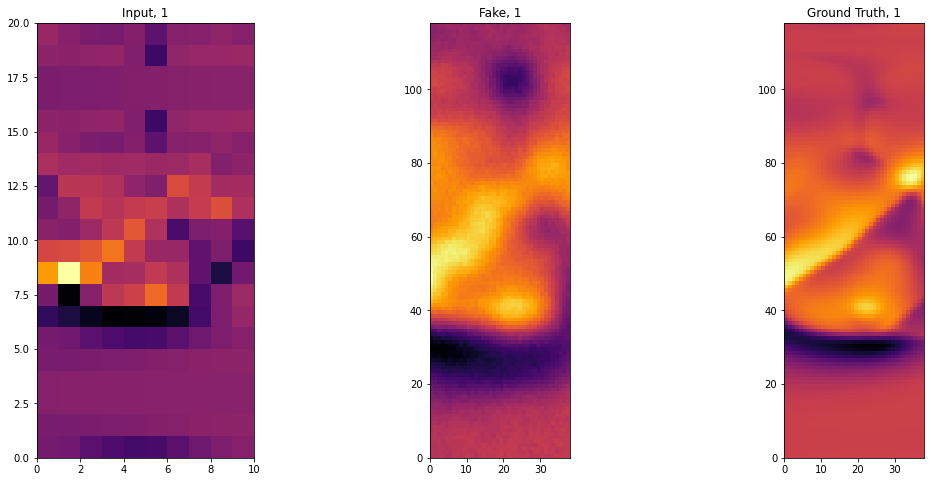

In [33]:
# randomly select image
data = earth_dataset[0]
x_input = data['input'].unsqueeze(0).to(device)
x_truth = data['truth'].unsqueeze(0).to(device)

with torch.no_grad():
    fake = gen(x_input).detach()

    
title_list = ['Input', "Fake", 'Ground Truth']
r_index = 1
var_to_plot = 3
    
# create image
color_scheme='inferno'
fig, axes = plt.subplots(1,3, figsize=(18,8))

for ax, title in zip(axes.flat, title_list):
    
                
    # downscaled data
    if title == 'Input':
                                
        ax.pcolormesh(x_input[0,var_to_plot,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)
                
    # downscaled data
    if title == 'Fake':
                
        ax.pcolormesh(fake[0,var_to_plot,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)
            
    # original data
    if title == 'Ground Truth':
           
        ax.pcolormesh(x_truth[0,var_to_plot,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)

plt.show()